In [1]:
import serial;

In [22]:
ser = serial.Serial('/dev/ttyACM1',115200,timeout=1)  # open serial port
print(ser.name)         # check which port was really used
#ser.write(b'hello')     # write a string
#ser.close()             # close port

/dev/ttyACM1


In [3]:
#ser.write(bytearray([0x80,0x55,0x5A]))
#print(ser.read(1000))

In [4]:
def GetDelay():
    a=0;
    D=[]
    Start=0x1000
    while a!=b'':
        a=ser.readline()[:8]
#        print(a)
        if a==b'': break;
        a=str(a,'UTF-8')
        a=Start-int(a,16)
#        print(a)
        if (a==0): break;
        D.append(a)
    return D;
#    print(a)
#print(a,a==b'02000000')


In [5]:
#ser.write(bytearray([0x80,0x55,0xFF]))
#Dold=D;
#print(Dold[:40])
#print(Dold2[:40])
#D=GetDelay();
#i0=0;
#print(D[i0:])
#Dold2=D
#D=Dold2


In [6]:
#ser.write(bytearray([0x00])) #input

In [7]:
#import matplotlib.pyplot as plt
#plt.hist(D,bins=81,range=(0,80),log=True);
#plt.title("Raw delay values")
#Cuts at 6,11,15


In [8]:
def NormDelays(D):
    return [(d+3+16)//20 for d in D]  #shorter (inbetween) delay = waiting for FIFO


In [15]:
def Decode(D2):
    previous="0";
    res=''
    for b in D2[1:]:
        if previous=="0":
            bit="0" if b<=2 else "01"
        else:
            if b==2:   bit="1"
            elif b==3: bit="0"
            else:      bit="01"
#    print(previous,b,bit)
        previous=bit[-1];
        res+=bit;
#print(res)
    res=res[2:]
#    print("len",len(res)//8)
    S=[]
    for x in range(len(res)//8):
        v1=int(res[x*8:x*8+8],2)
#    print(x,res[x*8:x*8+8],v1)
        S.append(v1)
    return(S)



#Should be 
# 0 = broadcast
# 37 = length
#  4 = function, 0 = register, 1=start, 16=end, 32x0

In [10]:
#S=Decode(D2)
#print(S)

In [11]:
import numpy as np
CRCtab=np.load("CRC_HBAT1.npy")
CRCtabl=[d%256 for d in CRCtab]
CRCtabh=[d//256 for d in CRCtab]
def CRCcheck(S1):
    crcl=0;crch=0;
    for b in S1:
        i=crcl ^ b
        crcl=crch ^ CRCtabl[i]
        crch=CRCtabh[i]
#    print(i,CRCtabh[i])
#    crch=crcl ^ CRCtabh[i]
#    crcl= CRCtabl[i]
    return crch*256+crcl

In [12]:
def MakeBroadcast(data,func=4,reg=0,serv1=1,serv2=16):
    assert(len(data)==32)
    data2=[func,reg,serv1,serv2]+data
    l=len(data2)+1
    data2=[0,l]+data2
    CRC=CRCcheck(data2)
    data2=data2+[CRC%256,CRC//256]
    assert(CRCcheck(data2)==0)
    return data2
#Mlookup=[0x55,0x56,0x59,0x5A,0x65,0x66,0x69,0x6A,0x95,0x96,0x99,0x9A,0xA5,0xA6,0xA9,0xAA]
Mlookup=[0xAA,0x6A,0x9A,0x5A,0xA6,0x66,0x96,0x56,0xA9,0x69,0x99,0x59,0xA5,0x65,0x95,0x55]
def ManchesterEncode(data):
#    Inverted: 0=input=high, 1=output=low. Applied at end.
#    Data clocked out MSB first, send on wire LSB first!
     data2=[0xff,0x0f,0xa8]  #------------_______-_-  Start sequence
     for d in data:
         data2+=[Mlookup[d//16]]
         data2+=[Mlookup[d%16]]
     data2+=[0xfd]
     return [255-d for d in data2]


In [13]:
def Loopback(TX2):
    #Calculte time between edges
    S=''
    for b in TX2:
        S+="{0:08b}".format(255-b)[::-1]
    print("Loopback bits:",S[:30])
    T=[0]
    for i in range(len(S)-1):
        if (S[i]=='1') and (S[i+1]=="0"): T+=[i]
    T=np.array(T[1:])
    T=T[1:]-T[:-1]
    print("Loopback delay:",T[:30])
    return T

In [23]:
TX1=MakeBroadcast(32*[0])
print("Packet to TX",TX1)
TX2=ManchesterEncode(TX1)
print("Mancher encoded bytes:",TX2)
T=Loopback(TX2)
S=Decode(T)
print("Loopback packet:",S,"CRC=",CRCcheck(S))
if True:
  ser.write(bytearray(TX2))
  D=GetDelay();
  D2=NormDelays(D)
  print("Received delays:",D2[:10])
  S=Decode(T)
  L=S[1]
  S1=S[:L+3]
  print("Received packet:",S1,"CRC=",CRCcheck(S1))


#Try to decode it


Packet to TX [0, 37, 4, 0, 1, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 207]
Mancher encoded bytes: [0, 240, 87, 85, 85, 101, 153, 85, 89, 85, 85, 85, 149, 149, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 149, 165, 90, 170, 2]
Loopback bits: 111111111111000000010101010101
Loopback delay: [8 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 3 2 2 2 3 3 2 2 2 2 2 2 2 2]
Loopback packet: [0, 37, 4, 0, 1, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 207] CRC= 0
Received delays: [8, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Received packet: [0, 37, 4, 0, 1, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 207] CRC= 0


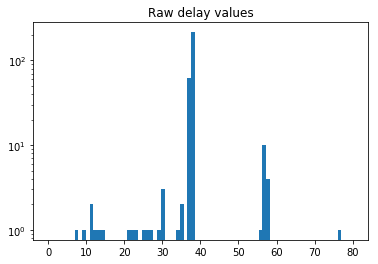

In [20]:
import matplotlib.pyplot as plt
plt.hist(D,bins=81,range=(0,80),log=True);
plt.title("Raw delay values");
#Cuts at 6,11,1

[2.0, 2.05, 2.05, 2.05, 2.0, 2.05, 2.05, 2.05, 2.05, 2.0, 2.05, 3.0, 3.05, 3.0, 4.0, 3.0, 2.05, 2.05, 2.0, 3.05, 3.0, 2.05, 2.05, 2.0, 2.05, 2.05, 1.25, 2.05, 2.05, 2.0, 2.05, 2.05, 2.05, 2.0, 2.05, 2.05, 3.0, 3.05, 2.0, 3.05, 3.0, 2.05, 2.05, 2.0, 2.05, 2.05, 2.05, 2.0, 2.05, 2.05, 0.8, 2.05, 2.05, 2.0, 2.05, 2.05, 2.05, 2.0, 2.05, 2.05, 2.05, 2.05, 2.0, 2.05, 2.05, 2.05, 2.0, 1.85, 2.05, 2.0, 2.05, 2.05, 2.05, 2.05, 2.0, 2.05, 1.2, 2.05, 2.05, 2.05]


Text(0.5,1,'Normalised delays')

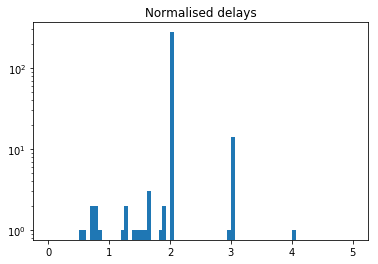

In [19]:
D2=[(d+3)/20. for d in D[1:]]
print(D2[:80])
plt.hist(D2,bins=80,range=(0,5),log=True);
plt.title("Normalised delays")

Packet [0, 37, 4, 0, 1, 16, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 60, 17]
CRC check 0


In [21]:
ser.close()

7.3203125